In [1]:
using KrylovKit: exponentiate
using Expokit: padm
include("LBFGSBcall.jl")
using LinearAlgebra
using SparseArrays
import Random as rnd; rnd.seed!(1234)
import Distributions as dist
using LaTeXStrings
using Plots; pgfplotsx()
using Printf
using BenchmarkTools

### Simulation parameters

In [2]:
# system parameters

# global dimension
NN::Int64 = 4
# local dimension
dd::Int64 = 3
# Hilbert space dimension
D_H::Int64 = dd^NN
# subspace dimension for the gate transfer
subdim::Int64 = 2^NN
# control qubit index
indexctrl::Int64 = 1
# target qubit index
indextgt::Int64 = 2;

In [3]:
# time parameters
TT::Float64 = 50.
dt::Float64 = 0.025;

In [4]:
# Hamiltonian parameters
twopi = 2 * π
omega_1 = 5 * twopi
omega_2 = 5.5 * twopi
delta_1 = -0.35 * twopi
omega_r = 7.5 * twopi
g_1 = 0.1 * twopi
g_2 = g_1

Delta_1 = omega_1 - omega_r
Delta_2 = omega_2 - omega_r
omega_tilde_1 = omega_1 + (g_1^2 / Delta_1)
omega_tilde_2 = omega_2 + (g_2^2 / Delta_2)

JJ = (g_1 * g_2 * (Delta_1 + Delta_2)) / (Delta_1 * Delta_2)
Delta = omega_tilde_2 - omega_tilde_1;

In [5]:
# scaling constants
e_unit::Float64 = abs(JJ)
t_unit::Float64 = 1 / e_unit;

In [6]:
# Hamiltonian final parameters

seed = 1234
rng = rnd.MersenneTwister(seed)

# sample from a gaussian distribution
perc = 0.1
Deltas = rnd.rand(dist.Normal(Delta, abs(perc * Delta)), NN) / e_unit
# detuning is zero for target qubit
Deltas[indextgt] = 0
deltas = rnd.rand(dist.Normal(delta_1, abs(perc * delta_1)), NN) / e_unit
JJs = rnd.rand(dist.Normal(JJ, abs(perc * JJ)), NN-1) / e_unit;

### Initialization functions

In [7]:
# defines simulation parameters
function inputparams(Τ::R=TT, τ::R=dt, unit::R=t_unit, info::Bool=true) where {R<:Real}
    nt = Τ / (τ * unit)
    res = nt % 1
    nt = trunc(Integer, nt)
    nψ = nt + 1

    if info
        println("eff time window:\t", round(Τ - res * τ; digits=2), " ns")
        println("nr time steps:\t\t", nt)
    end

    return nψ, τ
end;

In [8]:
# initializes the control vector
function initializectrls(n_iter::Int64, unit::Float64=e_unit)
    u_thr = 0.2 * 2 * π # 200 MHz
    return rnd.rand(dist.Uniform(-u_thr,u_thr), n_iter)  / unit
end;

In [9]:
# initialize problem
nctrl, dt = inputparams()
controls = initializectrls(nctrl);

eff time window:	50.0 ns
nr time steps:		113


### Jensen's method: sparse matrices ($N\geq 4$)

In [10]:
function create(N::Int64)
    diag = sqrt.([1:N-1;])
    return spdiagm(-1 => diag)
end

function annihilate(N::Int64)
    diag = sqrt.([1:N-1;])
    return spdiagm(1 => diag)
end;

In [11]:
function operatortrain(idxs::Vector{Int64}, args::Vector{SparseMatrixCSC{Float64, Int64}}, N::Int64=NN, d::Int64=dd)
    train = repeat([sparse(1.0I, d, d)], N)
    for (idx, arg) in zip(idxs, args)
        train[idx] = arg
    end
    return foldr(kron, train)
end

function statetrain(rep::Vector{Int64})
    kets = [[1,0,0], [0,1,0]]
    states = [kets[n+1] for n in rep]
    return foldr(kron, states)
end;

In [12]:
bdg = create(dd)
b = annihilate(dd)
bdgb = create(dd) * annihilate(dd);

$$\hat{H}_n = \sum^{N}_{j=1}\left[\Delta_j\hat{b}^\dagger_j\hat{b}_j+\frac{1}{2}\delta_j\hat{b}^\dagger_j\hat{b}_j(\hat{b}^\dagger_j\hat{b}_j-1)+\sum_{\langle i, j\rangle}J_{ij}(\hat{b}^\dagger_i\hat{b}_j+\hat{b}_i\hat{b}^\dagger_j)+u^{(j)}_n(\hat{b}^\dagger_j+\hat{b}_j)\right]=\hat{H}_d+\hat{H}^c_n$$

In [13]:
# control Hamiltonian
Hc = sum([operatortrain([n], [b + bdg]) for n in 1:NN])

# drift Hamiltonian
drift1 = sum([Deltas[n] * operatortrain([n], [bdgb]) for n in 1:NN])
drift2 = sum([1/2 * deltas[n] * operatortrain([n], [bdgb * (bdgb - I(dd))]) for n in 1:NN])
drift3 = sum([JJs[n] * (operatortrain([n, n+1], [bdg, b]) + operatortrain([n, n+1], [b, bdg])) for n in 1:NN-1])

Hd = (drift1 + drift2 + drift3)
@printf("degree of sparsity of Hd: %.2f%%", nnz(Hd)*100 / prod(size(Hd)))

# exponentiation is done once for the drift Hamiltonian
expHd = sparse(padm(-im * Hd * dt));

degree of sparsity of Hd: 4.50%

In [14]:
# generates an array of all possible combinations of NN 0s and 1s in reverse order
reps = reverse.(Iterators.product(fill(0:1,NN)...))[:]

inist = Matrix{ComplexF64}(undef, D_H, subdim)
tgtst = Matrix{ComplexF64}(undef, D_H, subdim)

for (idx, rep) in enumerate(reps)
    rep = [rep...]
    inist[:,idx] = statetrain(rep)
    # flip target qubit if CNOT
    if rep[indexctrl] == 1
        rep[indextgt] = (rep[indextgt] + 1) % 2
    end
    tgtst[:,idx] = statetrain(rep)
end;

In [15]:
# plotting function to assign the correct labels
function findket(idx::Int64, comb=reps)
    return replace(string(comb[idx]), "(" => "|", ")" => "⟩", "," => "")
end;

In [16]:
# implements the forward- and backward state time evolution
function evolvestate(ctrl::Vector{Float64}, ψini::M, χtgt::M, Hᶜ::SparseMatrixCSC{Float64}=Hc,
    eᴴᵈ::SparseMatrixCSC{ComplexF64}=expHd, 𝒟::Int64=D_H, 𝒮::Int64=subdim, τ::Float64=dt) where {M<:Matrix{ComplexF64}}

    N = size(ctrl,1)
    evψ = Array{ComplexF64, 3}(undef, 𝒟, 𝒮, N)
    evχ = Array{ComplexF64, 3}(undef, 𝒟, 𝒮, N)
    trotter = Matrix{SparseMatrixCSC{ComplexF64, Int64}}(undef, 2, N-1)

    evψ[:,:,1] = ψini
    evχ[:,:,N] = χtgt

    for n in 2:N
        Hᶜnext = ctrl[n] * Hᶜ
        Hᶜcurr = ctrl[n-1] * Hᶜ

        eᴴ⁽ⁿ⁺¹⁾ = sparse(padm(-im * Hᶜnext * τ / 2))
        eᴴ⁽ⁿ⁾   = sparse(padm(-im * Hᶜcurr * τ / 2))
        trotter[:,n-1] = [eᴴ⁽ⁿ⁺¹⁾, eᴴ⁽ⁿ⁾]

        𝒰(ψ) = eᴴ⁽ⁿ⁺¹⁾ * (eᴴᵈ * (eᴴ⁽ⁿ⁾ * ψ))
        for sd in 1:𝒮
            evψ[:,sd,n] = 𝒰(evψ[:,sd,n-1])
            evψ[:,sd,n] = evψ[:,sd,n] / norm(evψ[:,sd,n])
        end
    end
    
    for n in N:-1:2
        eᴴ⁽ⁿ⁺¹⁾, eᴴ⁽ⁿ⁾ = trotter[:,n-1]
        𝒰dg(χ) = eᴴ⁽ⁿ⁾' * (eᴴᵈ' * (eᴴ⁽ⁿ⁺¹⁾' * χ))
        for sd in 1:𝒮
            evχ[:,sd,n-1] = 𝒰dg(evχ[:,sd,n])
            evχ[:,sd,n-1] = evχ[:,sd,n-1] / norm(evχ[:,sd,n-1])
        end
    end

    overlap = [dot(evχ[:,sd,N], evψ[:,sd,N]) for sd in 1:𝒮]

    return evψ, evχ, overlap
end;

Suzuki-Trotter expansion of error log(δt²) ∼ 3.2
max and min are equal up to the (min/max): 14.8/16.6 -th digit


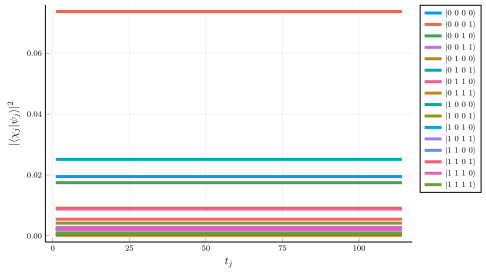

In [17]:
# CHECK: verify | ⟨ χ | ψ ⟩ |² constant

function absoverlap(evχ::A, evψ::A, sd::Int64) where {A<:Array}
    N = size(evψ,3)
    return [abs2(evχ[:,sd,n] ⋅ evψ[:,sd,n]) for n in 1:N]
end;

ev_psi, ev_chi, _ = evolvestate(controls, inist, tgtst)

O = absoverlap(ev_chi, ev_psi, 1)
Os = []
push!(Os, -log10(maximum(O) - minimum(O)))
p = plot(O, lw=3, label=findket(1), legend=true)
xlabel!(p, L"t_j")
ylabel!(p, L"|\langle\chi_j|\psi_j\rangle|^2")

for sd in 2:subdim
    O = absoverlap(ev_chi, ev_psi, sd)
    push!(Os, -log10(maximum(O) - minimum(O)))
    plot!(p, O, lw=3, label=findket(sd))
end

println("Suzuki-Trotter expansion of error log(δt²) ∼ ", round(-log10(dt^2); digits=2))
print("max and min are equal up to the (min/max): ")
println(round(minimum(Os); digits=1), "/", round(maximum(Os); digits=1), " -th digit")
p


In [18]:
# state-to-state phase-insensitive fidelity
# function jensen(ctrl::Matrix{Float64}, ψini::M=inist, χtgt::M=tgtst, Hᶜ::Matrix{Float64}=Hc, 𝒮::Int64=subdim, τ::Float64=dt) where {M<:Matrix{ComplexF64}}
#     N = size(ctrl,1)
#     evψ, evχ, overlap = evolvestate(ctrl, ψini, χtgt)
#     F_ss = 1/𝒮 * sum(abs2.(overlap))
#     f = 1/2 * (1 - F_ss)

#     g = zeros(N)
#     for sd in 1:𝒮
#         sandwich = [dot(evχ[:,sd,n], Hᶜ, evψ[:,sd,n]) for n in 1:N]
#         sandwich[1] *= 1/2
#         sandwich[N] *= 1/2
#         g += real(im * conj(overlap[sd]) * sandwich)
#     end
#     g *= τ / 𝒮
#     return (f, g)
# end;

In [19]:
# implements Jensen's method, returning both the fidelity and gradient
function jensen(ctrl::Vector{Float64}, ψini::M=inist, χtgt::M=tgtst, Hᶜ::SparseMatrixCSC{Float64}=Hc, 𝒮::Int64=subdim, τ::Float64=dt) where {M<:Matrix{ComplexF64}}
    N = size(ctrl,1)
    evψ, evχ, overlap = evolvestate(ctrl, ψini, χtgt)
    Θ = sum(overlap)
    F_sm = abs2(1/𝒮 * Θ) # square-modulus fidelity
    f = 1/2 * (1 - F_sm)
    Θ = conj(Θ)

    g = zeros(N)
    for sd in 1:𝒮
        sandwich = [dot(evχ[:,sd,n], Hᶜ, evψ[:,sd,n]) for n in 1:N]
        sandwich[1] *= 1/2
        sandwich[N] *= 1/2
        g += real(im * Θ * sandwich)
    end
    g *= τ / 𝒮^2
    return (f, g)
end;

In [20]:
bound = 0.2 * 2 * π / e_unit
jfout, jxout, jnormgrad = LBFGSBcall(jensen, controls, bound); # ∼𝒪(minutes)

starting task ...
terminating task ...n: 847
TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


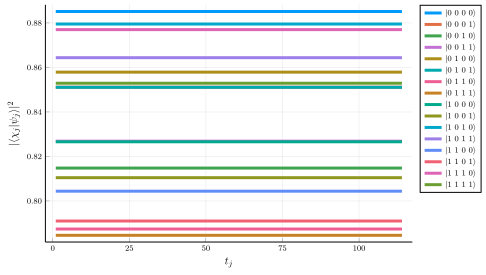

In [21]:
ev_psi, ev_chi, _ = evolvestate(jxout, inist, tgtst)

O = absoverlap(ev_chi, ev_psi, 1)
p = plot(O, lw=3, label=findket(1), legend=true)
xlabel!(p, L"t_j")
ylabel!(p, L"|\langle\chi_j|\psi_j\rangle|^2")

for sd in 2:subdim
    O = absoverlap(ev_chi, ev_psi, sd)
    plot!(p, O, lw=3, label=findket(sd))
end
p

In [22]:
@benchmark evolvestate($controls, $inist, $tgtst)

BenchmarkTools.Trial: 11 samples with 1 evaluation.
 Range (min … max):  352.721 ms … 750.329 ms  ┊ GC (min … max): 2.10% … 1.98%
 Time  (median):     443.802 ms               ┊ GC (median):    1.82%
 Time  (mean ± σ):   484.866 ms ± 125.683 ms  ┊ GC (mean ± σ):  1.86% ± 0.44%

  █▁     ▁  ▁  ▁             ▁   ▁▁   ▁                       ▁  
  ██▁▁▁▁▁█▁▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁██▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  353 ms           Histogram: frequency by time          750 ms <

 Memory estimate: 610.69 MiB, allocs estimate: 44471.

### Krylov exponentiation

In [23]:
# implements the forward- and backward state time evolution via Krylov exponentiation
function evolvekrylov(ctrl::Vector{Float64}, ψini::M, χtgt::M, Hᶜ::SparseMatrixCSC{Float64}=Hc,
    Hᵈ::SparseMatrixCSC{Float64}=Hd, 𝒟::Int64=D_H, 𝒮::Int64=subdim, τ::Float64=dt) where {M<:Matrix{ComplexF64}}

    N = size(ctrl,1)
    evψ = Array{ComplexF64, 3}(undef, 𝒟, 𝒮, N)
    evχ = Array{ComplexF64, 3}(undef, 𝒟, 𝒮, N)
    exact = Vector{SparseMatrixCSC{ComplexF64}}(undef, N-1)

    evψ[:,:,1] = ψini
    evχ[:,:,N] = χtgt

    for n in 2:N
        Hᶜnext = ctrl[n] * Hᶜ
        Hᶜcurr = ctrl[n-1] * Hᶜ
        Hᵗᵒᵗ = Hᵈ + 1/2 * (Hᶜnext + Hᶜcurr)
        exact[n-1] = Hᵗᵒᵗ

        for sd in 1:𝒮
            evψ[:,sd,n], info = exponentiate(Hᵗᵒᵗ, -im*τ, evψ[:,sd,n-1])
            info.converged==0 && throw("exponentiate did not converge!")
            evψ[:,sd,n] = evψ[:,sd,n] / norm(evψ[:,sd,n])
        end
    end

    for n in N:-1:2
        Hᵗᵒᵗ = exact[n-1]

        for sd in 1:𝒮
            evχ[:,sd,n-1], info = exponentiate(Hᵗᵒᵗ', im*τ, evχ[:,sd,n])
            info.converged==0 && throw("exponentiate did not converge!")
            evχ[:,sd,n-1] = evχ[:,sd,n-1] / norm(evχ[:,sd,n-1])
        end
    end

    overlap = [dot(evχ[:,sd,N], evψ[:,sd,N]) for sd in 1:𝒮]

    return evψ, evχ, overlap
end;

In [24]:
# implements the time evolution, returning both the fidelity and gradient
function krylov(ctrl::Vector{Float64}, ψini::M=inist, χtgt::M=tgtst, Hᶜ::SparseMatrixCSC{Float64}=Hc, 𝒮::Int64=subdim, τ::Float64=dt) where {M<:Matrix{ComplexF64}}
    N = size(ctrl,1)
    evψ, evχ, overlap = evolvekrylov(ctrl, ψini, χtgt)
    Θ = sum(overlap)
    F_sm = abs2(1/𝒮 * Θ) # square-modulus fidelity
    f = 1/2 * (1 - F_sm)
    Θ = conj(Θ)

    g = zeros(N)
    for sd in 1:𝒮
        sandwich = [dot(evχ[:,sd,n], Hᶜ, evψ[:,sd,n]) for n in 1:N]
        sandwich[1] *= 1/2
        sandwich[N] *= 1/2
        g += real(im * Θ * sandwich)
    end
    g *= τ / 𝒮^2
    return (f, g)
end;

In [25]:
bound = 0.2 * 2 * π / e_unit
kfout, kxout, knormgrad = LBFGSBcall(krylov, controls, bound); # ∼𝒪(minutes), much slower! yet convergence is reached, no degenerate behaviour

starting task ...
terminating task ...n: 361
CONVERGENCE REACHED


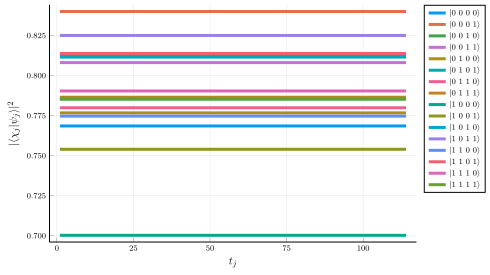

In [26]:
ev_psi, ev_chi, _ = evolvekrylov(kxout, inist, tgtst)

O = absoverlap(ev_chi, ev_psi, 1)
p = plot(O, lw=3, label=findket(1), legend=true)
xlabel!(p, L"t_j")
ylabel!(p, L"|\langle\chi_j|\psi_j\rangle|^2")

for sd in 2:subdim
    O = absoverlap(ev_chi, ev_psi, sd)
    plot!(p, O, lw=3, label=findket(sd))
end
p

In [27]:
@benchmark evolvekrylov($controls, $inist, $tgtst)

BenchmarkTools.Trial: 3 samples with 1 evaluation.
 Range (min … max):  1.422 s …    2.537 s  ┊ GC (min … max): 3.72% … 2.58%
 Time  (median):     2.068 s               ┊ GC (median):    2.56%
 Time  (mean ± σ):   2.009 s ± 559.749 ms  ┊ GC (mean ± σ):  2.60% ± 0.93%

  █                                █                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.42 s         Histogram: frequency by time         2.54 s <

 Memory estimate: 550.16 MiB, allocs estimate: 223892.

### Comparison

final fidelity Jensen: 	0.8339853404192394
final fidelity Krylov: 	0.78623936831769


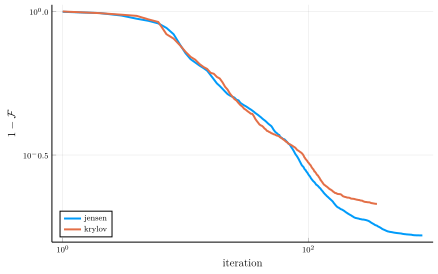

In [28]:
println("final fidelity Jensen: \t", 1 - last(jfout)*2)
println("final fidelity Krylov: \t", 1 - last(kfout)*2)
p = plot(2*jfout, lw=2, label="jensen", legend=:bottomleft, xaxis=:log, yaxis=:log)
plot!(2*kfout, lw=2, label="krylov")
xlabel!(p, "iteration")
ylabel!(p, L"1-\mathcal{F}")

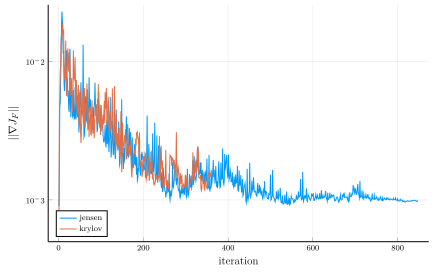

In [29]:
p = plot(jnormgrad, lw=1, label="jensen", legend=:bottomleft, yaxis=:log)
plot!(knormgrad, lw=1, label="krylov")
xlabel!(p, "iteration")
ylabel!(p, L"||\nabla J_F||")

In [30]:
println("jensen error in propagation\n")
println("kry. opt. controls in kry. evolution:\t", 1-2*krylov(kxout)[1])
println("jen. opt. controls in kry. evolution:\t", 1-2*krylov(jxout)[1])

jensen error in propagation

kry. opt. controls in kry. evolution:	0.78623936831769
jen. opt. controls in kry. evolution:	2.551305058329234e-5
